<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L5_MC_reliability_estimation_with_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**Introduction to Probability Estimation**

* Estimating probabilities is fundamental in various fields, including engineering, finance, and science.

* A common approach involves using Monte Carlo simulations, where a model is evaluated numerous times to estimate the likelihood of specific outcomes.

* This method is particularly useful when dealing with complex systems where analytical solutions are intractable.

*  Numerical Estiamtion of Chance Constraints and Reliability  




In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm, multivariate_normal
import scipy.stats as stats
from scipy.linalg import cholesky
from numpy.random import multivariate_normal as mvn_rnd


Start with a system with an algebraic reliability performance function

### Define reliability performance function
* $  g(x;\theta)$
* $\theta$ is a vector of model parameters
* $x$ is a random vector distributed as $f_X(x)$



 ### Define failure indicator function

Given a random $x \sim f_X(x)$
* The sytem fails to perfom adequatelly if $g(x;\theta) \leq 0 $.

   $
   I(x) =
   \begin{cases}
   1 & \text{if } g(x; \theta) \leq 0, \\
   0 & \text{otherwise.}
   \end{cases}
   $



In [34]:
# Define the Performance Function g(x,theta)
def g_fun(x1, x2, theta = None):
    """
    Performance function g(x,theta).
    Args:
        x1, x2: Input variables.
        theta: Design parameters
    Returns:
        Value of the performance function.
    """
    if theta is None:
      theta = [1, 1, 0.5]

    return 2 - theta[0]*x1 + theta[1]* x2 + theta[2]*x1*x2  # Example quadratic function

# Define the Indicator Function I(x)
def I_fun(x1, x2):
    """
    Indicator function I(x).
    Args:
        x1, x2: Input variables.
    Returns:
        1 if g(x) <= 0 (failure), 0 otherwise.
    """
    return g_fun(x1, x2) <= 0


# Define an arbitrary data generation mechanism (DGM)

* Used to generate samples/scenarios from the density as follows: $x\sim f_X(x)$.


In [35]:
# =====================================================
# Define the Probabilistic Model
# =====================================================


def DGM(n_samples: int = 5000, n_dim=2):
  """
  A data generating mechanism
    Args:
        n_samples: integer number of samples
        n_dim: number of dimensions of x
    Returns:
        X: the samples
        marginals: the marginal distributions
        corr_matrix: a correlation matrix

  """
  np.random.seed(42)

  # Define marginal distributions (e.g., Lognormal and Weibull)
  marginals = [stats.lognorm(s=0.5, scale=np.exp(0.5)),   # Lognormal
              stats.weibull_min(c=12.0, scale=1.0)]       # Weibul

   # Define correlation matrix
  if n_dim == 2:
      corr_matrix = np.array([[1.0, 0.6], [0.6, 1.0]])
  else:
      corr_matrix = np.eye(n_dim) # no correlation if ndim>2

  # Generate correlated samples from a multivariate gaussian distribution
  Z = mvn_rnd(mean=np.zeros(n_dim),
              cov=corr_matrix,
              size=n_samples)

  U = stats.norm.cdf(Z)  # Transform to uniform space
  X = np.zeros_like(U)   # X contains all zeros same size as U

  for i in range(2):
    X[:, i] = marginals[i].ppf(U[:, i])  # Transform to physical space using inverse CDF

  return X, marginals, corr_matrix


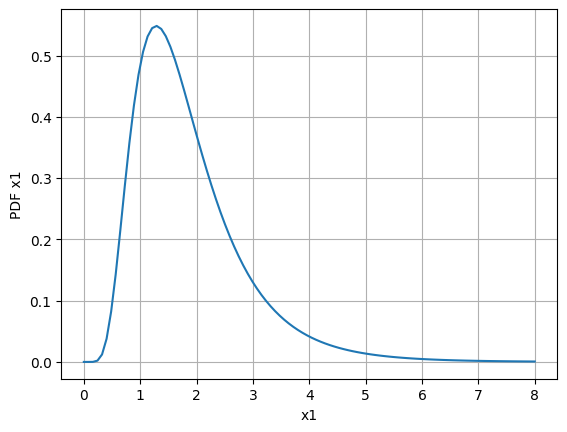

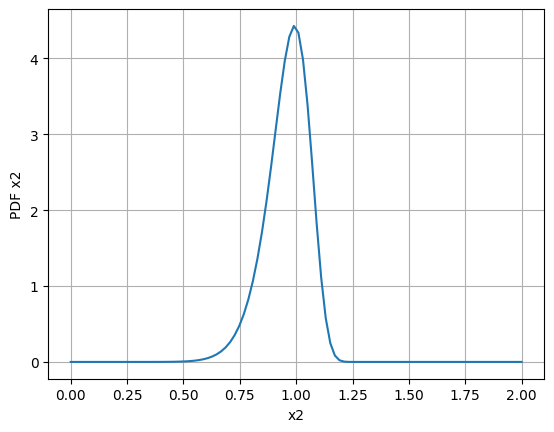

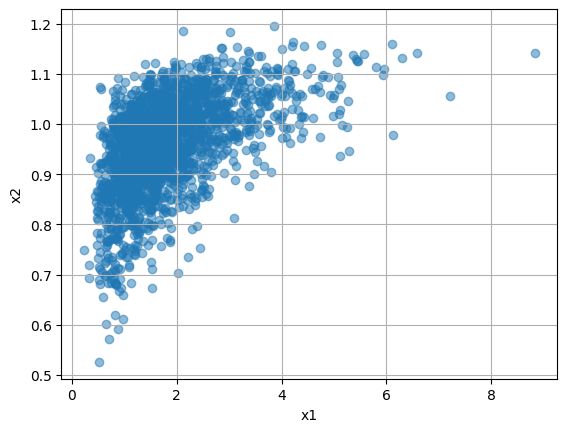

In [36]:
# example
X, marginals, corr_matrix =  DGM(2000)

x_linspace = np.linspace(-0,8,100)
plt.plot(x_linspace, marginals[0].pdf(x_linspace))
plt.xlabel('x1')
plt.ylabel('PDF x1')
plt.grid()
plt.show()

x_linspace = np.linspace(-0,2,100)
plt.plot(x_linspace, marginals[1].pdf(x_linspace))
plt.xlabel('x2')
plt.ylabel('PDF x2')
plt.grid()
plt.show()

plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()
plt.show()

### Monte Carlo (MC) Estimation

Monte Carlo estimation provides a sample-based approach to approximate the failure probability $P_f(\theta)$ or equivalently $R(\theta)$.

1. Draw $n$ independent samples $\{x_i\}_{i=1}^n$ from the distribution $f_X(x)$

2. For each sample $x_i$, evaluate $g(x_i; \theta)$ and $I(x_i)$.  


3. The Monte Carlo **Estimation** of $P_f(\theta)$ is the expectation of the indicator function

   $$
   \hat{P}_f(\theta) = \frac{1}{N} \sum_{i=1}^N I(x_i).
   $$



4. Using the complement, the estimate $P_R(\theta) = 1 - \hat{P}_f(\theta)$.

5. Vsiualize failure region $F =\{x : g(x)\leq 0\}$
     
6.  By the law of large numbers, $\hat{P}_f(\theta)$ and $\hat{R}(\theta)$ **converge** to their true values as $N \to \infty$. The standard error decreases as $\mathcal{O}(1/\sqrt{N})$.

In [38]:
# Monte Carlo Estimation
# 1. sample
X, _, _ =  DGM(int(1e5))

# 2. evalluate system response
I_sams = I_fun(X[:, 0], X[:, 1])

# 3. samples-based estimate
mc_estimate_pof = np.mean(I_sams)
print(f"Estimated probability of failure = {mc_estimate_pof:.6f}")

# 4. samples-based estimate
mc_estimate_reliability = np.mean(I_sams==0)
print(f"Estimated probability of the reliability = {mc_estimate_reliability:.6f}")


Estimated probability of failure = 0.002180
Estimated probability of the reliability = 0.997820


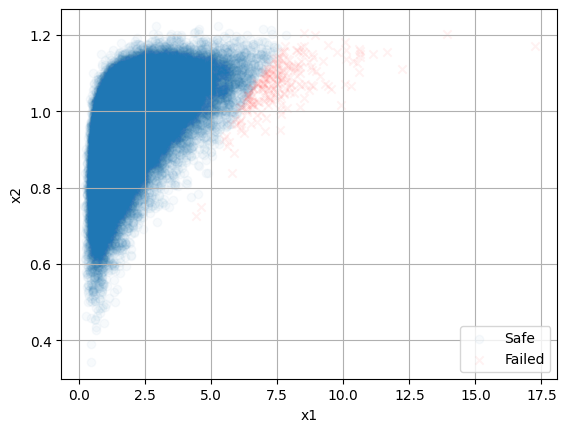

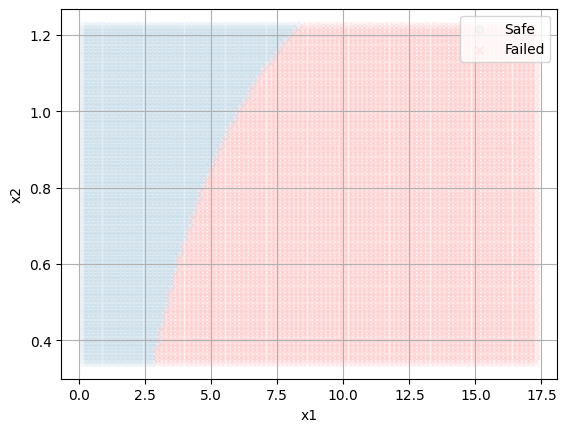

In [44]:
# 5.1 Visualization of failure region
plt.scatter(X[I_sams==0,0], X[I_sams==0,1], alpha=0.03, label=f"Safe")
plt.scatter(X[I_sams==1,0], X[I_sams==1,1], alpha=0.05, c='r', marker='x', label="Failed")
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid()
plt.show()

# 5.2 Visualization of failure region
X_grid_x1, X_grid_x2 = np.meshgrid(np.linspace(min(X[:,0]),max(X[:,0]),100), np.linspace(min(X[:,1]),max(X[:,1]),100))
X_grid = np.stack((X_grid_x1.ravel(), X_grid_x2.ravel()), axis=-1)
I_grid = np.array([I_fun(x[0], x[1]) for x in X_grid])
plt.scatter(X_grid[I_grid==0,0], X_grid[I_grid==0,1], alpha=0.03, label=f"Safe")
plt.scatter(X_grid[I_grid==1,0], X_grid[I_grid==1,1], alpha=0.05, c='r', marker='x', label="Failed")
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid()
plt.show()



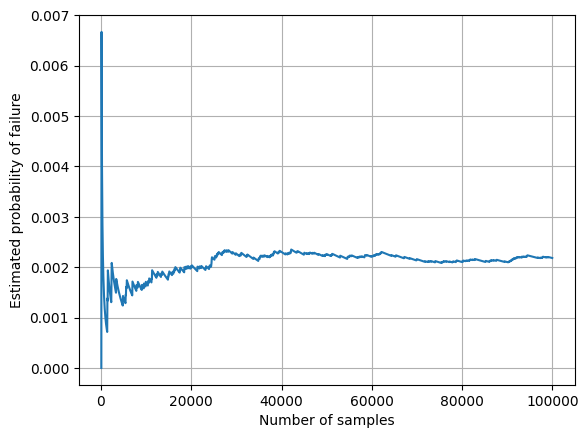

In [51]:
# 6. Convergence of the Pf estimator
steps_2_eval = range(100,len(I_sams),50)
Pf_step_k = np.array([np.mean(I_sams[:k]) for k in steps_2_eval])
plt.plot(steps_2_eval, Pf_step_k)
plt.xlabel('Number of samples')
plt.ylabel('Estimated probability of failure')
plt.grid()
plt.show()

In [52]:
import numpy as np
from scipy.stats import binom
#todo: revise
def smallest_rank_for_quantile(n, alpha, beta):
    """
    Find the smallest rank k such that P(x_alpha <= X_(k)) >= beta.

    Args:
        n: Sample size.
        alpha: Quantile level (0 < alpha < 1).
        beta: Confidence level (0 < beta < 1).

    Returns:
        k: The smallest rank satisfying the condition.
    """
    # Iterate over possible ranks k
    for k in range(1, n + 1):
        # Compute the binomial CDF F(n, alpha)(k-1)
        cdf = binom.cdf(k - 1, n, alpha)
        if cdf >= beta:
            return k
    return n  # If no k satisfies the condition, return n

def minimum_sample_size_for_quantile(k, alpha, beta):
    """
    Find the smallest sample size n such that P(x_alpha <= X_(k)) >= beta.

    Args:
        k: Rank of the order statistic.
        alpha: Quantile level (0 < alpha < 1).
        beta: Confidence level (0 < beta < 1).

    Returns:
        n: The smallest sample size satisfying the condition.
    """
    # Start with n = k and increment until the condition is satisfied
    n = k
    while True:
        # Compute the binomial CDF F(n, alpha)(k-1)
        cdf = binom.cdf(k - 1, n, alpha)
        if cdf >= beta:
            return n
        n += 1

def minimum_sample_size_for_probability(p, beta):
    """
    Compute the minimum sample size required to estimate a small probability p
    with confidence beta.

    Args:
        p: Probability to estimate (0 < p < 1).
        beta: Confidence level (0 < beta < 1).

    Returns:
        n: Minimum sample size.
    """
    if p <= 0 or p >= 1:
        raise ValueError("Probability p must be in (0, 1).")
    if beta <= 0 or beta >= 1:
        raise ValueError("Confidence beta must be in (0, 1).")

    # Compute the minimum sample size
    n = np.ceil(np.log(1 - beta) / np.log(1 - p))
    return int(n)


# Example usage
n = 100  # Sample size
alpha = 0.95  # Quantile level (95th percentile)
beta = 0.95  # Confidence level (90%)

# Find the smallest rank k
k_sol = smallest_rank_for_quantile(n, alpha, beta)
print(f"Smallest rank k for n={n}, alpha={alpha}, beta={beta}: {k_sol}")

# Find the minimum sample size n
k = 95  # Desired rank
n_min = minimum_sample_size_for_quantile(k, alpha, beta)
print(f"Minimum sample size for k={k}, alpha={alpha}, beta={beta}: {n_min}")


# Example usage
p = 0.001  # Probability to estimate
beta = 0.99  # Confidence level

n_min = minimum_sample_size_for_probability(p, beta)
print(f"Minimum sample size to estimate p={p} with confidence beta={beta}: {n_min}")
print(f"Minimum sample size to estimate p={p} with confidence beta={beta} is {p*n_min} times 1/Pf")

Smallest rank k for n=100, alpha=0.95, beta=0.95: 99
Minimum sample size for k=95, alpha=0.95, beta=0.95: 95
Minimum sample size to estimate p=0.001 with confidence beta=0.99: 4603
Minimum sample size to estimate p=0.001 with confidence beta=0.99 is 4.603 times 1/Pf


In [53]:
# REVISE
# Step 1: Transform X to U-space (standard normal space)
def transform_to_u_space(x1, x2):
    """
    Transform X to U-space using the inverse CDF.
    Args:
        x1, x2: Input variables in X-space.
    Returns:
        u1, u2: Transformed variables in U-space.
    """
    u1 = stats.norm.ppf(f_x1.cdf(x1))
    u2 = stats.norm.ppf(f_x2.cdf(x2))
    return u1, u2

# Step 2: Compute the gradient of g(x) in U-space (useful to optimize)
def gradient_g_fun(u1, u2):
    """
    Compute the gradient of g(x) in U-space.
    Args:
        u1, u2: Input variables in U-space.
    Returns:
        grad_g: Gradient vector [dg/du1, dg/du2].
    """
    # Transform U back to X-space
    x1 = f_x1.ppf(stats.norm.cdf(u1))
    x2 = f_x2.ppf(stats.norm.cdf(u2))

    # Compute partial derivatives of g(x) with respect to x1 and x2
    dg_dx1 = 2 * (x1 + 3)
    dg_dx2 = 6 * (x2 + 2)

    # Compute partial derivatives of x1 and x2 with respect to u1 and u2
    dx1_du1 = sigma_X1 * np.exp(-0.5 * u1**2) / np.sqrt(2 * np.pi)
    dx2_du2 = sigma_X2 * np.exp(-0.5 * u2**2) / np.sqrt(2 * np.pi)

    # Chain rule: dg/du1 = dg/dx1 * dx1/du1, dg/du2 = dg/dx2 * dx2/du2
    dg_du1 = dg_dx1 * dx1_du1
    dg_du2 = dg_dx2 * dx2_du2

    return np.array([dg_du1, dg_du2])


# Step 3: Find the Most Probable Point (MPP) using an optimization algorithm
from scipy.optimize import minimize

def find_mpp():
    """
    Find the Most Probable Point (MPP) in U-space.
    Returns:
        u_mpp: MPP in U-space.
    """
    # Objective function: Minimize the distance to the origin subject to g(x) = 0
    def objective(u):
        return np.linalg.norm(u)

    # Constraint: g(x) = 0
    def constraint(u):
        x1 = f_x1.ppf(stats.norm.cdf(u[0]))
        x2 = f_x2.ppf(stats.norm.cdf(u[1]))
        return g_fun(x1, x2)

    # Initial guess (origin in U-space)
    u0 = np.array([0, 0])

    # Solve the optimization problem
    result = minimize(objective, u0, constraints={'type': 'eq', 'fun': constraint})
    return result.x


In [ ]:
# Define means and standard deviations for X1 and X2
mu_X1, sigma_X1 = 200, 20
mu_X2, sigma_X2 = 150, 10

# Define the performance function parameters in U-space
gradient_g = np.array([20, 10])  # Gradient components of g(U)
g_u0 = 50  # Performance function at U = (0,0)

# Compute the magnitude of the gradient
norm_gradient = np.linalg.norm(gradient_g)

# Compute the reliability index beta
beta = abs(g_u0) / norm_gradient

# Compute the probability of failure
pf_form = norm.cdf(-beta)

print(f"FORM")
print(f"Reliability index (β): {beta:.4f}")
print(f"Probability of failure FORM (P_f): {pf_form:.4f}")
print(f"Reliability FORM (1-P_f): {1-pf_form:.4f}")

print(f"Monte Carlo")
print(f"Monte Carlo Estimate of P[g(x) <= 0]: {mc_estimate_pof}")
print(f"Monte Carlo Estimate of P[g(x) > 0]: {1- mc_estimate_pof}")


FORM
Reliability index (β): 2.2361
Probability of failure FORM (P_f): 0.0127
Reliability FORM (1-P_f): 0.9873
Monte Carlo
Monte Carlo Estimate of P[g(x) <= 0]: 1.46e-06
Monte Carlo Estimate of P[g(x) > 0]: 0.99999854


In [ ]:
# Define the normal distributions for x1 and x2
mu_x1, mu_x2 = 2, 3
sigma_x1, sigma_x2 = 1, 1

# Create a grid of points for x1 and x2
x1_range = np.linspace(mu_x1 - 5*sigma_x1, mu_x1 + 5*sigma_x1, 100)
x2_range = np.linspace(mu_x2 - 5*sigma_x2, mu_x2 + 5*sigma_x2, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)

# Calculate the joint probability density function (PDF)
f_x1_x2 = norm.pdf(X1, loc=mu_x1, scale=sigma_x1) * norm.pdf(X2, loc=mu_x2, scale=sigma_x2)

# Data transformation to standard space: x -> u Hasofer-Lind 2nd Moment transformation
U1 = (X1 - mu_x1) / sigma_x1
U2 = (X2 - mu_x2) / sigma_x2


# Transform g(x) to g(u)
def g_u(u1, u2):
    x1 = u1 * sigma_x1 + mu_x1
    x2 = u2 * sigma_x2 + mu_x2
    return g_fun(x1, x2)

# Define the indicator function in the standard space
def I_u(u1,u2):
    return g_u(u1,u2) <= 0

# Plot the iso-probability curves of f(x1, x2)
plt.figure(figsize=(10, 8))
CS = plt.contour(X1, X2, f_x1_x2, levels=7, colors='blue')
plt.clabel(CS, inline=1, fontsize=10)

# Plot the failure region defined by I(x)
failure_region = np.where(I_fun(X1, X2) == 1)
plt.scatter(X1[failure_region], X2[failure_region], color='red', s=1, label='Failure Region')
plt.grid()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Failure region and joint PDF')
plt.legend()
plt.show()


# Calculate the joint PDF in the standard space
f_u1_u2 = norm.pdf(U1, loc=0, scale=1) * norm.pdf(U2, loc=0, scale=1)

# Plot I(u) and f(u)
plt.figure(figsize=(10, 8))
CS = plt.contour(U1, U2, f_u1_u2, levels=10, colors='blue')
plt.clabel(CS, inline=1, fontsize=10)

failure_region_u = np.where(I_u(U1, U2) == 1)
plt.scatter(U1[failure_region_u], U2[failure_region_u], color='red', s=1, label='Failure Region (U)')
plt.grid()
plt.xlabel('u1')
plt.ylabel('u2')
plt.title('Failure region and joint PDF in standard space')
plt.legend()
plt.show()

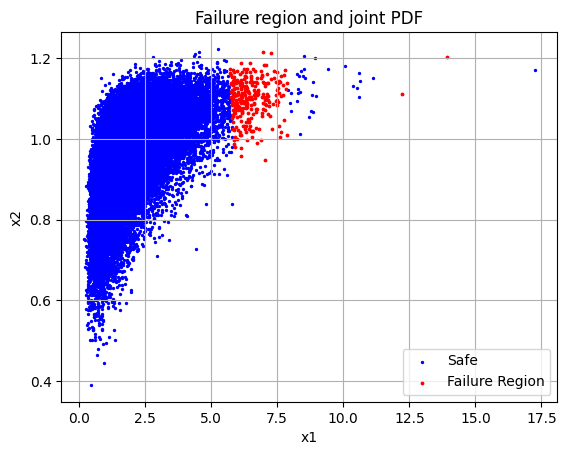

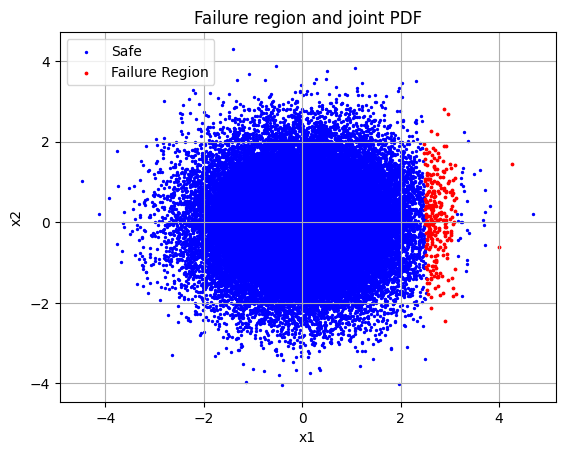

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm

X, marginals, corr_matrix =  DGM(50000)

# Define the non-transformed limit state function g(x)
def g(x1, x2):
    return  10 - 0.5*np.exp(x1*np.sin(x2+x1))

# Define the indicator function I(x) for failure region
def I(x1, x2):
    return g(x1, x2) <= 0  # Failure region where g(x) <= 0

# Plot the failure region in the original space
X1, X2 = X[:, 0], X[:, 1]
failure_region = np.where(I(X1, X2) == 1)
plt.scatter(X1[I(X1, X2) == 0], X2[I(X1, X2) == 0], color='blue', s=2, label='Safe')
plt.scatter(X1[failure_region], X2[failure_region], color='red', s=3, label='Failure Region')
plt.grid()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Failure region and joint PDF')
plt.legend()
plt.show()

# Data transformation to standard space: x -> u (Rosenblatt transformation)
U_transformed = generalized_nataf_transform(X, marginals, corr_matrix)

U1, U2 = U_transformed[:, 0], U_transformed[:, 1]
# Plot the failure region in the original space
plt.scatter(U1[I(X1, X2) == 0], U2[I(X1, X2) == 0], color='blue', s=2, label='Safe')
plt.scatter(U1[failure_region], U2[failure_region], color='red', s=3, label='Failure Region')
plt.grid()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Failure region and joint PDF')
plt.legend()
plt.show()


In [ ]:
import time

tac = time.time()
X, _, _ =  DGM(int(2e6))
I_samples = I(X[:,0], X[:,1])
Pf_MC = np.mean(I_samples)

tic = time.time()

print(f"Monte Carlo Simulation")
print(f"Unreliability $P_F=$: {Pf_MC}")
print(f"Reliability: {1-Pf_MC}")
print(f"Time elapsed: {tic-tac}  [seconds]")

# Convergence of the estimator
steps_2_eval = range(100,len(I_samples),250)
Pf_step_k = np.array([np.mean(I_samples[:k]) for k in steps_2_eval])
plt.plot(steps_2_eval, Pf_step_k)
plt.xlabel('Number of samples')
plt.ylabel('Estimated probability of failure')
plt.grid()
plt.show()



In [ ]:
import numpy as np
from scipy.stats import norm, lognorm
from scipy.optimize import minimize

# Define the limit state function g(x)
def g(x1, x2):
    return x1**2 + 3*x2**2 - 6

# Define the Rosenblatt transformation
def ros_transformation(x1, x2, mu_x1, sigma_x1, mu_x2, sigma_x2):
    # Apply the CDF transformations to get U1 and U2
    F_X1 = norm.cdf(x1, loc=mu_x1, scale=sigma_x1)
    F_X2 = lognorm.cdf(x2, s=sigma_x2, scale=np.exp(mu_x2))

    # Apply the inverse CDF to get the standard normal variables
    U1 = norm.ppf(F_X1)
    U2 = norm.ppf(F_X2)
    return U1, U2

# Define the optimization function to find the MPP
def mpp_optimization(mu_x1, sigma_x1, mu_x2, sigma_x2):
    # Objective function to minimize (g(x) should be minimized)
    def objective(u):
        # Transform back to original space
        x1 = norm.ppf(norm.cdf(u[0])) * sigma_x1 + mu_x1
        x2 = lognorm.ppf(norm.cdf(u[1]), s=sigma_x2, scale=np.exp(mu_x2))
        return g(x1, x2)

    # Initial guess (start near the origin)
    u_init = np.array([0, 0])

    # Perform optimization (search for MPP)
    result = minimize(objective, u_init, bounds=[(-10, 10), (-10, 10)])

    # Get the MPP
    u_mpp = result.x
    return u_mpp

# Define the function to calculate the reliability
def calculate_reliability(beta):
    # Reliability is the CDF of the standard normal evaluated at beta
    return norm.cdf(beta)

# Define the main function to execute FORM
def form(mu_x1, sigma_x1, mu_x2, sigma_x2):
    # Step 1: Find the MPP in U-space
    u_mpp = mpp_optimization(mu_x1, sigma_x1, mu_x2, sigma_x2)

    # Step 2: Calculate the reliability index beta
    beta = np.linalg.norm(u_mpp)  # Reliability index is the distance from the origin

    # Step 3: Calculate the reliability
    reliability = calculate_reliability(beta)

    return beta, reliability

# Define the parameters of the distributions
mu_x1, sigma_x1 = 2, 1  # Normal distribution parameters
mu_x2, sigma_x2 = 0.5, 0.2  # Lognormal distribution parameters

# Perform FORM analysis
beta, reliability = form(mu_x1, sigma_x1, mu_x2, sigma_x2)

print("Reliability Index (beta):", beta)
print("Reliability (R):", reliability)


Reliability Index (beta): 10.198039031682757
Reliability (R): 1.0
